- 삼성전자 주식 다음달 가격 얼마일까?(회귀)
- 비트코인 다음 달 어떻게 될까?(회귀)
- 전날 비트 코인 상승하면 다음날 주가와의 상관관계(correlation)

1. 목표
 1. Y: 미래 30일의 국내 특정 주식과 비트코인의 종가
 1. X: 최근 60일간의 데이터
    1. step: 하루 간격
    1. 양  : 1년(2018.06 ~ 2019.06)
1. 데이터 획득
 1. 국내 기업 1개, 비트코인
1. 데이터 정제
 1. 누락
1. 데이터 전처리
 1. 특수기호, 문자 -> 숫자 변환
 1. 두 데이터 날짜 기준으로 통합(axis =1)
    1. 외국(2018-01-01), 국내(2018.1.1)
    1. 날짜 포맷을 YYYY-MM-DD 으로 변환 후 통합
1. 비트코인 가격 변화와 주가와의 상관관계(correlation)
 1. cov()
1. 입력X / 출력Y 분리
 1. m개의 x,y 쌍
 1. x(60, 10~15), (국내증시컬럼+비트코인컬럼) -> reshape -> (m, 60*15)
     - x+x+x+x+.... = X
 1. y(30, 1) == (m, 30)
1. 학습용/검증용(test) 분리
 1. 섞으면 안되므로 직접 분리
 1. 가장 오래된 데이터 10% 를 검증용으로 사용
1. 모델선정
 1. Ridge 모델, 학습용 데이터로 학습
 1. 성능측정
1. 그래프로 시각화
 1. 과거
 1. 미래의 예측 predict(x(1, (60 * 15)) -> return -> y_hat(1, 30 * 2)
     1. 미래 예측(1, 30 * 2) -> (30, 2) -> 국내(30), 비트코인(30)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
samsung_url = 'https://finance.naver.com/item/sise_day.nhn?code=005930'

In [4]:
tables = pd.read_html(samsung_url+'&page'+str(1))
len(tables)
samsung = tables[0]
samsung.shape

(15, 7)

In [5]:
# 페이지로 되어있는 자료를 읽어오자
for t in tables:
    print(t.shape)

(15, 7)
(1, 12)


In [6]:
samsungs = []
for i in range(1, 28):
    tables = pd.read_html(samsung_url+'&page='+str(i))
    samsung = tables[0]
    samsungs.append(samsung)
len(samsungs)

27

In [7]:
samsung = pd.concat(samsungs, axis=0)
samsung.shape

(405, 7)

In [8]:
samsung.tail()

,날짜,종가,전일비,시가,고가,저가,거래량
10,2018.06.18,46600.0,1050.0,47600.0,47650.0,46200.0,16661870.0
11,2018.06.15,47650.0,550.0,48500.0,48700.0,47650.0,17080892.0
12,2018.06.14,48200.0,1200.0,49000.0,49000.0,48200.0,20971729.0
13,2018.06.12,49400.0,500.0,49700.0,49800.0,49250.0,12110569.0
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## =============================================

In [9]:
btc_url = 'https://coinmarketcap.com/currencies/bitcoin/historical-data/'
btc_url += '?start=20180601&end=20190601'
tables = pd.read_html(btc_url)
btc = tables[0]
len(tables)

2

In [13]:
btc.head(3)

,Date,Open*,High,Low,Close**,Volume,Market Cap
0,"Jun 01, 2019",8573.84,8625.60,8481.58,8564.02,22488303544,151890214310
1,"May 31, 2019",8320.29,8586.66,8172.55,8574.50,25365190957,152059886414
2,"May 30, 2019",8661.76,9008.31,8221.27,8319.47,29246528551,147525141134


### 데이터 통합
 - 두 데이터 날짜 기준으로 통합(axis=1)
 - 외국(2018-01-01), 국내(2018.1.1)
 - 날짜 포맷을 YYYY-MM-DD 으로 변환 후 통합

In [14]:
btc.shape, samsung.shape

((366, 7), (405, 7))

In [15]:
# 날짜를 인덱스로
samsung = samsung.set_index('날짜')

In [16]:
btc = btc.set_index('Date')

In [17]:
samsung.tail()

,종가,전일비,시가,고가,저가,거래량
날짜,,,,,,
2018.06.18,46600.0,1050.0,47600.0,47650.0,46200.0,16661870.0
2018.06.15,47650.0,550.0,48500.0,48700.0,47650.0,17080892.0
2018.06.14,48200.0,1200.0,49000.0,49000.0,48200.0,20971729.0
2018.06.12,49400.0,500.0,49700.0,49800.0,49250.0,12110569.0
NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# 인덱스 타입이 object
# samsung.index
# btc.index

In [19]:
# 날짜 인덱스를 공통된 날짜 형태로 바꾸기- 테스트
pd.to_datetime(btc.index)

DatetimeIndex(['2019-06-01', '2019-05-31', '2019-05-30', '2019-05-29',
               '2019-05-28', '2019-05-27', '2019-05-26', '2019-05-25',
               '2019-05-24', '2019-05-23',
               ...
               '2018-06-10', '2018-06-09', '2018-06-08', '2018-06-07',
               '2018-06-06', '2018-06-05', '2018-06-04', '2018-06-03',
               '2018-06-02', '2018-06-01'],
              dtype='datetime64[ns]', name='Date', length=366, freq=None)

In [20]:
pd.to_datetime(samsung.index)

DatetimeIndex([       'NaT', '2019-07-17', '2019-07-16', '2019-07-15',
               '2019-07-12', '2019-07-11',        'NaT',        'NaT',
                      'NaT', '2019-07-10',
               ...
               '2018-06-20',        'NaT',        'NaT',        'NaT',
               '2018-06-19', '2018-06-18', '2018-06-15', '2018-06-14',
               '2018-06-12',        'NaT'],
              dtype='datetime64[ns]', name='날짜', length=405, freq=None)

In [21]:
btc.index

Index(['Jun 01, 2019', 'May 31, 2019', 'May 30, 2019', 'May 29, 2019',
       'May 28, 2019', 'May 27, 2019', 'May 26, 2019', 'May 25, 2019',
       'May 24, 2019', 'May 23, 2019',
       ...
       'Jun 10, 2018', 'Jun 09, 2018', 'Jun 08, 2018', 'Jun 07, 2018',
       'Jun 06, 2018', 'Jun 05, 2018', 'Jun 04, 2018', 'Jun 03, 2018',
       'Jun 02, 2018', 'Jun 01, 2018'],
      dtype='object', name='Date', length=366)

In [22]:
# 날짜 인덱스를 공통된 날짜 형태로 바꾸기
btc.index = pd.to_datetime(btc.index)
samsung.index = pd.to_datetime(samsung.index)

In [23]:
btc.index

DatetimeIndex(['2019-06-01', '2019-05-31', '2019-05-30', '2019-05-29',
               '2019-05-28', '2019-05-27', '2019-05-26', '2019-05-25',
               '2019-05-24', '2019-05-23',
               ...
               '2018-06-10', '2018-06-09', '2018-06-08', '2018-06-07',
               '2018-06-06', '2018-06-05', '2018-06-04', '2018-06-03',
               '2018-06-02', '2018-06-01'],
              dtype='datetime64[ns]', name='Date', length=366, freq=None)

In [24]:
pd.concat((samsung, btc), axis = 1).dropna()

,종가,전일비,시가,고가,저가,거래량,Open*,High,Low,Close**,Volume,Market Cap
2018-06-12,49400.0,500.0,49700.0,49800.0,49250.0,12110569.0,6905.82,6907.96,6542.08,6582.36,4.654380e+09,1.124919e+11
2018-06-14,48200.0,1200.0,49000.0,49000.0,48200.0,20971729.0,6342.75,6707.14,6334.46,6675.35,5.138710e+09,1.141060e+11
2018-06-15,47650.0,550.0,48500.0,48700.0,47650.0,17080892.0,6674.08,6681.08,6433.87,6456.58,3.955390e+09,1.103787e+11
2018-06-18,46600.0,1050.0,47600.0,47650.0,46200.0,16661870.0,6510.07,6781.14,6446.68,6734.82,4.039200e+09,1.151762e+11
2018-06-19,47000.0,400.0,47200.0,47350.0,46500.0,15217971.0,6742.39,6822.50,6709.92,6769.94,4.057030e+09,1.157899e+11
2018-06-20,47000.0,0.0,47450.0,47600.0,46850.0,12959316.0,6770.76,6821.56,6611.88,6776.55,3.888640e+09,1.159164e+11
2018-06-21,47050.0,50.0,47900.0,47900.0,47050.0,10015541.0,6780.09,6810.94,6715.17,6729.74,3.529130e+09,1.151297e+11
2018-06-22,47250.0,200.0,47000.0,47250.0,46200.0,10298006.0,6737.88,6747.08,6006.60,6083.69,5.079810e+09,1.040888e+11
2018-06-25,46650.0,600.0,47050.0,47050.0,46150.0,10587711.0,6171.97,6327.37,6119.68,6249.18,5.500810e+09,1.069585e+11
2018-06-26,47000.0,350.0,45900.0,47300.0,45900.0,11223166.0,6253.55,6290.16,6093.67,6093.67,3.279760e+09,1.043079e+11


In [25]:
df = pd.concat((samsung, btc), axis = 1).dropna()
df.shape

(238, 12)

In [26]:
df.dtypes

종가            float64
전일비           float64
시가            float64
고가            float64
저가            float64
거래량           float64
Open*         float64
High          float64
Low           float64
Close**       float64
Volume        float64
Market Cap    float64
dtype: object

In [27]:
# 데이터 형식이 실수, 누락이 없다라는 것 확인
df.describe()

,종가,전일비,시가,고가,저가,거래량,Open*,High,Low,Close**,Volume,Market Cap
count,238.000000,238.000000,238.000000,238.000000,238.000000,2.380000e+02,238.000000,238.000000,238.000000,238.000000,2.380000e+02,2.380000e+02
mean,44387.605042,525.630252,44386.344538,44827.731092,43928.781513,1.125068e+07,5551.271429,5661.370420,5440.614916,5549.998319,8.172230e+09,9.653763e+10
std,2458.152659,448.737824,2506.311122,2455.177922,2452.919854,3.947392e+06,1502.689293,1532.706733,1463.776694,1500.547182,6.280760e+09,2.583165e+10
min,37450.000000,0.000000,37450.000000,37600.000000,36850.000000,4.762460e+06,3253.120000,3329.560000,3206.540000,3242.480000,3.230550e+09,5.649438e+10
25%,42825.000000,200.000000,42900.000000,43362.500000,42400.000000,8.264758e+06,3952.742500,4010.227500,3892.452500,3948.847500,4.317575e+09,6.908419e+10
50%,44875.000000,400.000000,44825.000000,45350.000000,44375.000000,1.079669e+07,6118.780000,6222.350000,5922.050000,6088.680000,5.360503e+09,1.048558e+11
75%,46250.000000,787.500000,46400.000000,46800.000000,45987.500000,1.298628e+07,6583.592500,6696.670000,6464.457500,6584.737500,9.384137e+09,1.134231e+11
max,49400.000000,2200.000000,49700.000000,49800.000000,49250.000000,2.625465e+07,8802.760000,9008.310000,8668.700000,8805.780000,3.316720e+10,1.560938e+11


In [28]:
df.isna().sum()

종가            0
전일비           0
시가            0
고가            0
저가            0
거래량           0
Open*         0
High          0
Low           0
Close**       0
Volume        0
Market Cap    0
dtype: int64

In [29]:
df.cov() # 상관관계

,종가,전일비,시가,고가,저가,거래량,Open*,High,Low,Close**,Volume,Market Cap
종가,6.042514e+06,-9.195742e+03,6.000157e+06,5.970250e+06,5.963322e+06,-1.930123e+09,1.248934e+06,1.252432e+06,1.259312e+06,1.269176e+06,-1.282251e+12,2.108281e+13
전일비,-9.195742e+03,2.013656e+05,-5.429121e+03,3.376937e+04,-4.351505e+04,8.596179e+08,-1.500312e+04,-2.092045e+04,-1.700095e+04,-2.508242e+04,-1.878279e+11,-4.562096e+11
시가,6.000157e+06,-5.429121e+03,6.281595e+06,6.083239e+06,6.083897e+06,-1.723036e+09,1.280736e+06,1.284714e+06,1.283180e+06,1.295527e+06,-1.150881e+12,2.152860e+13
고가,5.970250e+06,3.376937e+04,6.083239e+06,6.027899e+06,5.964947e+06,-1.477937e+09,1.268946e+06,1.272595e+06,1.278285e+06,1.287754e+06,-1.163626e+12,2.141166e+13
저가,5.963322e+06,-4.351505e+04,6.083897e+06,5.964947e+06,6.016816e+06,-2.078121e+09,1.261385e+06,1.268900e+06,1.267965e+06,1.283399e+06,-1.279886e+12,2.130511e+13
거래량,-1.930123e+09,8.596179e+08,-1.723036e+09,-1.477937e+09,-2.078121e+09,1.558191e+13,-7.581746e+08,-8.301517e+08,-7.410975e+08,-8.141871e+08,1.004035e+15,-1.362150e+16
Open*,1.248934e+06,-1.500312e+04,1.280736e+06,1.268946e+06,1.261385e+06,-7.581746e+08,2.258075e+06,2.293102e+06,2.189019e+06,2.234986e+06,1.781998e+12,3.841701e+13
High,1.252432e+06,-2.092045e+04,1.284714e+06,1.272595e+06,1.268900e+06,-8.301517e+08,2.293102e+06,2.349190e+06,2.229188e+06,2.290825e+06,2.058850e+12,3.939482e+13
Low,1.259312e+06,-1.700095e+04,1.283180e+06,1.278285e+06,1.267965e+06,-7.410975e+08,2.189019e+06,2.229188e+06,2.142642e+06,2.189010e+06,1.655155e+12,3.762813e+13
Close**,1.269176e+06,-2.508242e+04,1.295527e+06,1.287754e+06,1.283399e+06,-8.141871e+08,2.234986e+06,2.290825e+06,2.189010e+06,2.251642e+06,1.914711e+12,3.872246e+13


### 전날 비트 코인 상승하면 다음날 주가 와의 상관관계(correlation)

In [30]:
비트코인변화 = df['Open*'] - df['Close**']
주가변화 = df['시가'] - df['종가']
과거비트코인변화 = 비트코인변화.iloc[:-1]
다음날주가변화 = 주가변화.iloc[1:]

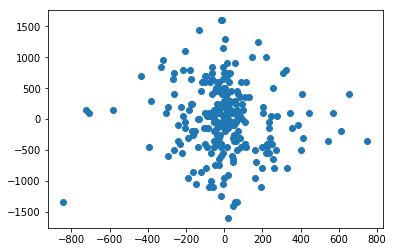

In [31]:
p = plt.scatter(과거비트코인변화, 다음날주가변화)
# 상관관계가 없어 보인다

In [32]:
np.corrcoef(과거비트코인변화, 다음날주가변화)
# 상관계수가 0에 가까우므로 둘은 상관관계가 거의 없다고 볼 수 있다.

array([[ 1.        , -0.06514652],
       [-0.06514652,  1.        ]])

7. 입력X / 출력Y 분리
  - m개의 x,y 쌍
  - x(60, 10~15), (국내증시컬럼+비트코인컬럼) -> reshape -> (m, 60*15)
  - x+x+x+x+.... = X
  - y(30, 1) == (m, 30)

In [33]:
input_seq = 60
output_seq = 30
m = len(df) - (input_seq + output_seq) +1
len(df), m

(238, 149)

In [34]:
for i in range(m):
    x = df.iloc[i:i+input_seq]
    y = df.iloc[i+input_seq:i+input_seq+output_seq][['종가', 'Close**']]
    #print(x.shape, y.shape)
y

,종가,Close**
2019-04-18,45600.0,5298.39
2019-04-19,45300.0,5303.81
2019-04-22,45350.0,5399.37
2019-04-23,45200.0,5572.36
2019-04-24,44750.0,5464.87
2019-04-25,44650.0,5210.52
2019-04-26,44850.0,5279.35
2019-04-29,46150.0,5247.35
2019-04-30,45850.0,5350.73
2019-05-02,45900.0,5505.28


In [41]:
# 쌓아둘 곳 정하여 저장
x_list = []
y_list = []
for i in range(m):
    x = df.iloc[i:i+input_seq]
    y = df.iloc[i+input_seq:i+input_seq+output_seq][['종가', 'Close**']]
    #print(x.shape, y.shape)
    x_list.append(x)
    y_list.append(y)
y_list[:2]

[                 종가  Close**
 2018-09-06  46100.0  6529.17
 2018-09-07  44900.0  6467.07
 2018-09-10  45500.0  6329.70
 2018-09-11  45050.0  6321.20
 2018-09-12  44550.0  6351.80
 2018-09-13  44050.0  6517.31
 2018-09-14  45850.0  6512.71
 2018-09-17  45150.0  6281.20
 2018-09-18  45500.0  6371.30
 2018-09-19  46150.0  6398.54
 2018-09-20  47250.0  6519.67
 2018-09-21  47400.0  6734.95
 2018-09-27  47500.0  6676.75
 2018-09-28  46450.0  6644.13
 2018-10-01  46350.0  6589.62
 2018-10-02  45700.0  6556.10
 2018-10-04  44700.0  6576.69
 2018-10-05  44700.0  6622.48
 2018-10-08  44950.0  6652.23
 2018-10-10  45300.0  6585.53
 2018-10-11  43100.0  6256.24
 2018-10-12  44000.0  6274.58
 2018-10-15  43800.0  6596.54
 2018-10-16  43600.0  6596.11
 2018-10-17  44150.0  6544.43
 2018-10-18  44050.0  6476.71
 2018-10-19  43900.0  6465.41
 2018-10-22  43550.0  6487.16
 2018-10-23  43050.0  6475.74
 2018-10-24  42550.0  6495.84,                  종가  Close**
 2018-09-07  44900.0  6467.07
 2018-09-1

In [47]:
len(x_list) #(155, 60, 12)

155

In [48]:
type(x_list)

list

In [50]:
# numpy로 변환
x_3d = np.stack(x_list, axis =0)
y_3d = np.stack(y_list, axis =0)
x_3d.shape, y_3d.shape

((155, 60, 12), (155, 30, 2))

In [51]:
# 비트코인 종가 위치 확인
df.columns

Index(['종가', '전일비', '시가', '고가', '저가', '거래량', 'Open*', 'High', 'Low', 'Close**',
       'Volume', 'Market Cap'],
      dtype='object')

In [52]:
kor_close_index = 0
btc_close_index = 9

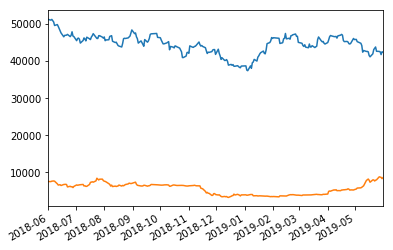

In [53]:
df['종가'].plot()
df['Close**'].plot()

### tain/test 분리
 - test 10%

In [54]:
test_ratio = 0.1
test_m = int(len(x_3d)*test_ratio)
test_m

15

In [55]:
x_test = x_3d[:test_m]
x_train = x_3d[test_m:]
y_test = y_3d[:test_m]
y_train = y_3d[test_m:]

In [ ]:
# model, Linear Regression, 가중치를 작게 제약하는 모델
from sklearn.linear_model import Ridge
# model = Ridge().fit(x_train,y_train)  # 에러남 -> 차원이 2차원 이하만 가능

In [56]:
# 2차원으로 reshape(변경)
m = len(x_3d)
x_2d = np.reshape(x_3d,[m,-1])
y_2d = np.reshape(y_3d,[m,-1])

x_test = x_2d[:test_m]
x_train = x_2d[test_m:]
y_test = y_2d[:test_m]
y_train = y_2d[test_m:]

In [57]:
from sklearn.linear_model import Ridge, Lasso
model = Ridge(normalize = True, solver='lsqr').fit(x_train,y_train)

In [58]:
model.score(x_train, y_train), model.score(x_test, y_test)  # 트레이닝은 잘되었지만 테스트는 부족 -> 과적합

(0.9736899384676927, -11.805314083668307)

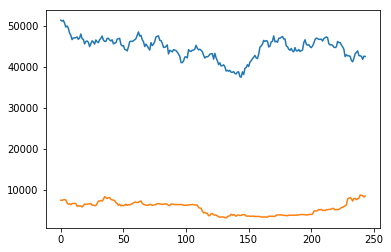

In [59]:
plt.plot(df['종가'].values)
plt.plot(df['Close**'].values)

In [76]:
# 가장 최근 데이터
recent = df.iloc[-input_seq:]
#recent = np.array(recent)
recent = np.reshape(np.array(recent), [1, -1])
recent.shape  #12(column) *60(row) 쭉 이어 붙인다
#recent

(1, 720)

In [127]:
# 모양을 바꿔준다
recent = df.iloc[-input_seq:]
recent = np.reshape(np.array(recent),[1, -1])
recent.shape

(1, 720)

In [85]:
p = model.predict(recent)#미래 예측
p = np.reshape(p, [output_seq, -1])  # (1, 60) -> (30, x) 형태로 바꿔라
p.shape

(30, 2)

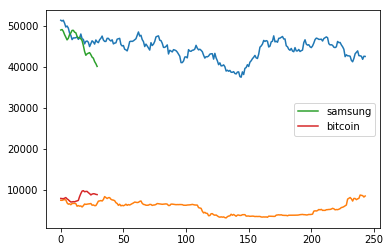

In [86]:
plt.plot(df['종가'].values)
plt.plot(df['Close**'].values)
plt.plot(p[:,0], label = 'samsung')
plt.plot(p[:,1], label = 'bitcoin')
plt.legend()

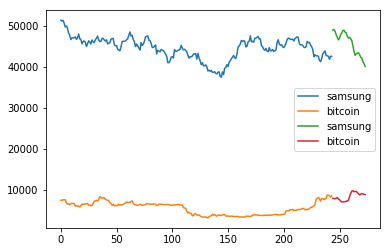

In [87]:
xm = len(df)
plt.plot(np.arange(xm), df['종가'].values, label='samsung')
plt.plot(np.arange(xm), df['Close**'].values, label='bitcoin')
plt.plot(np.arange(xm,xm+output_seq), p[:, 0], label='samsung')
plt.plot(np.arange(xm,xm+output_seq), p[:, 1], label='bitcoin')
plt.legend()